In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("retail_store_inventory.csv")
df["Date"] = pd.to_datetime(df["Date"], errors='coerce') #handle datatype 

store1=df[df["Store ID"]=="S001"]
store2=df[df["Store ID"]=="S002"]
store3=df[df["Store ID"]=="S003"]
store4=df[df["Store ID"]=="S004"]
store5=df[df["Store ID"]=="S005"]

data=store1 # 1. store 

sp1 = data.groupby(['Date','Product ID']).sum()
sp1_filtered = sp1.loc[sp1.index.get_level_values('Product ID') == 'P0001']
sp1_filtered_reset = sp1_filtered.reset_index(level='Product ID', drop=True)
unit = sp1_filtered_reset[['Units Sold']]

/var/folders/_z/0s1nj30n17q95bnhv10ll0500000gn/T/ipykernel_22294/2034747233.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sp1 = data.groupby(['Date','Product ID']).sum()


In [3]:
unit = unit.reset_index()

In [4]:
unit

,Date,Units Sold
0,2022-01-01,127
1,2022-01-02,81
2,2022-01-03,5
3,2022-01-04,58
4,2022-01-05,147
...,...,...
726,2023-12-28,67
727,2023-12-29,168
728,2023-12-30,30
729,2023-12-31,26


In [5]:
# Prepare the data for Prophet
# Rename columns to 'ds' (date) and 'y' (target variable)
prophet_data = unit[['Date', 'Units Sold']].copy()
prophet_data.rename(columns={'Date': 'ds', 'Units Sold': 'y'}, inplace=True)

# Split data into training and testing sets
train = prophet_data.iloc[:-30]  # All but the last 30 days
test = prophet_data.iloc[-30:]   # Last 30 days for testing

In [6]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to the data
model.fit(train)

16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Extract predictions for the testing period
predicted = forecast[['ds', 'yhat']].iloc[-30:]

In [8]:
# Calculate performance metrics
mae = mean_absolute_error(test['y'], predicted['yhat'])
mse = mean_squared_error(test['y'], predicted['yhat'])
rmse = mse ** 0.5
mape = (abs(test['y'] - predicted['yhat']) / test['y']).mean() * 100

# Print the metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 71.46
MSE: 7145.61
RMSE: 84.53
MAPE: 339.17%


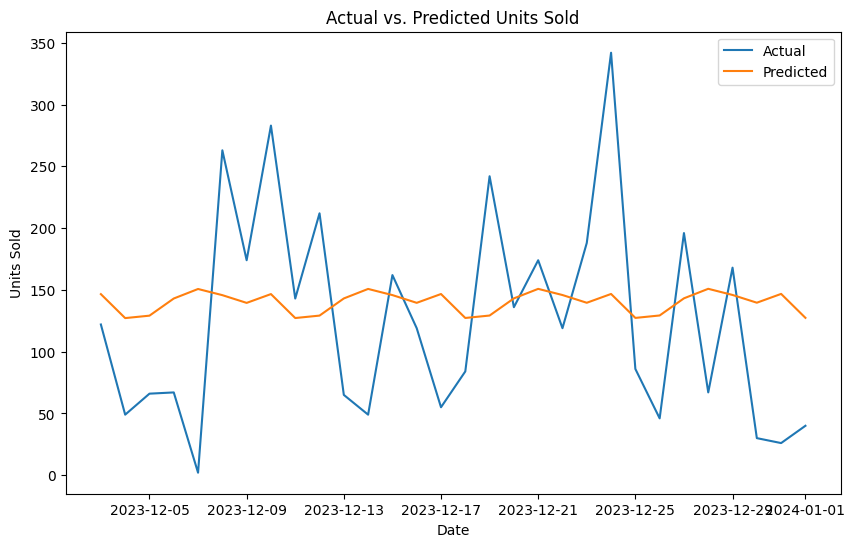

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(predicted['ds'], predicted['yhat'], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()


In [10]:
# Define a function for training and evaluation
def evaluate_prophet(train, test, params):
    # Initialize the model with parameters
    model = Prophet(
        growth=params.get('growth', 'linear'),
        seasonality_mode=params.get('seasonality_mode', 'additive'),
        changepoint_prior_scale=params.get('changepoint_prior_scale', 0.05),
        yearly_seasonality=params.get('yearly_seasonality', True),
        weekly_seasonality=params.get('weekly_seasonality', True),
        daily_seasonality=params.get('daily_seasonality', False)
    )
    model.fit(train)
    
    # Create future dataframe and predict
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    
    # Calculate MAE for the testing period
    forecast_test = forecast[-len(test):]
    mae = mean_absolute_error(test['y'], forecast_test['yhat'])
    return mae

In [11]:
# Define hyperparameter grid
param_grid = {
    'growth': ['linear'],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False]
}

In [12]:
# Split data into training and testing sets
train = prophet_data.iloc[:-30]  # All but the last 30 days
test = prophet_data.iloc[-30:]   # Last 30 days for testing

# Grid search for best hyperparameters
best_params = None
best_mae = float('inf')

In [13]:
for growth in param_grid['growth']:
    for seasonality_mode in param_grid['seasonality_mode']:
        for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
            for yearly in param_grid['yearly_seasonality']:
                for weekly in param_grid['weekly_seasonality']:
                    params = {
                        'growth': growth,
                        'seasonality_mode': seasonality_mode,
                        'changepoint_prior_scale': changepoint_prior_scale,
                        'yearly_seasonality': yearly,
                        'weekly_seasonality': weekly
                    }
                    # Evaluate the model
                    mae = evaluate_prophet(train, test, params)
                    if mae < best_mae:
                        best_mae = mae
                        best_params = params

# Print the best parameters and MAE
print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae:.2f}")

16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:41 - cmdstanpy - INFO - Chain [1] done processing
16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:42 - cmdstanpy - INFO - Chain [1] done processing
16:50:42 - cmdstanpy - INFO - Chain [1] start processing
16:50:42 - cmdstanpy - INFO - Chain [1] done processing
16:50:42 - cmdstanpy - INFO - Chain [1] start processing
16:50:42 - cmdstanpy - INFO - Chain [1] done processing
16:50:42 - cmdstanpy - INFO - Chain [1] start processing
16:50:42 - cmdstanpy - INFO - Chain [1] done processing
16:50:42 - cmdstanpy - INFO - Chain [1] start processing
16:50:42 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'growth': 'linear', 'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'yearly_seasonality': True, 'weekly_seasonality': True}
Best MAE: 69.49


16:50:44 - cmdstanpy - INFO - Chain [1] start processing
16:50:44 - cmdstanpy - INFO - Chain [1] done processing


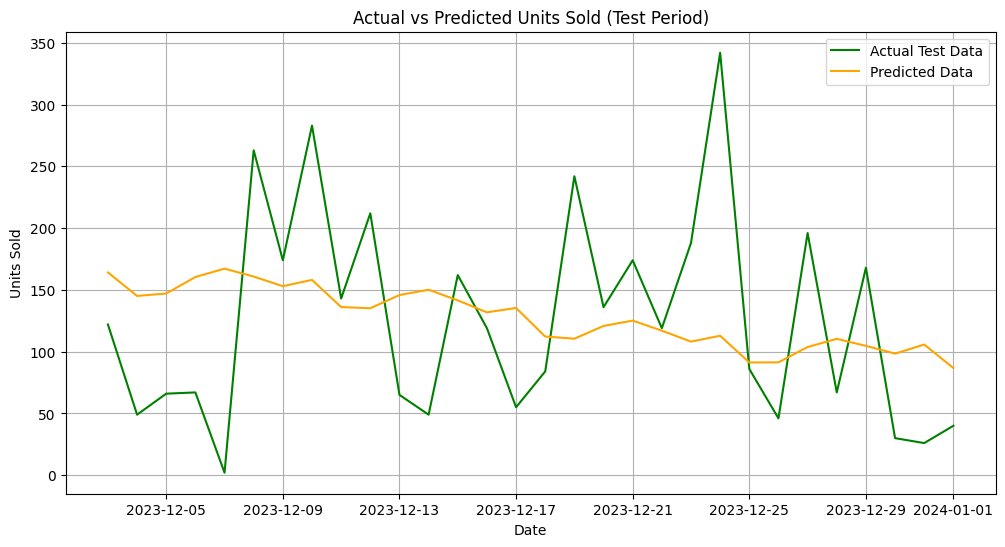

In [14]:
# Function to plot test and predicted data
def plot_test_vs_prediction(test, forecast):
    # Extract predictions for the test period
    forecast_test = forecast[-len(test):]
    
    plt.figure(figsize=(12, 6))
    
    # Plot actual test data
    plt.plot(test['ds'], test['y'], label='Actual Test Data', color='green')
    
    # Plot predicted data
    plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Predicted Data', color='orange')
    
    # Add labels, title, and legend
    plt.title('Actual vs Predicted Units Sold (Test Period)')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.grid()
    plt.show()

# Use the best model to forecast and plot the test vs prediction
best_model = Prophet(
    growth=best_params['growth'],
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
    daily_seasonality=False
)
best_model.fit(train)

# Create future dataframe and predict
future = best_model.make_future_dataframe(periods=len(test))
forecast = best_model.predict(future)

# Plot test vs predicted data
plot_test_vs_prediction(test, forecast)
